In [11]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline
import GraphHelpers as GH

Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28

In [8]:
AlbedoDF = pd.read_pickle('.\DataFrames\DailyAlbedoCor.pkl')
EstAlbedoDF = pd.read_pickle('.\DataFrames\DailyAlbedoCorEstInt.pkl')
TnRData = pd.read_pickle('.\DataFrames\TempAndMet.pkl')
TnRHourlyMeans = TnRData.resample('H').mean()
TnRHourlyMeans.sort_index(axis=1,inplace=True)
TnRHourlySums = TnRData.resample('H').sum()
TnRHourlySums.sort_index(axis=1,inplace=True)
AlbedoHourly = AlbedoDF.resample('H').ffill().reindex(TnRHourlyMeans.index)
AlbedoHourly.sort_index(axis=1,inplace=True)
EstAlbedoHourly = EstAlbedoDF.resample('H').ffill().reindex(TnRHourlyMeans.index)
EstAlbedoHourly.sort_index(axis=1,inplace=True)

In [12]:
GPs = GH.SetGraphicsPatterns(TnRData.BelowCanopyPAR.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '250', '50']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '250', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Dryland   0     -  orange  0.15   o  orange
          250   -   green  0.15   o   green
          50    -  purple  0.15   o  purple
Irrigated 0    --  orange  0.45   ^   white
          250  --   green  0.45   ^   white
          50   --  purple  0.45   ^   white


## Set up dataframe for net radiation measured on detailed heat balance plots

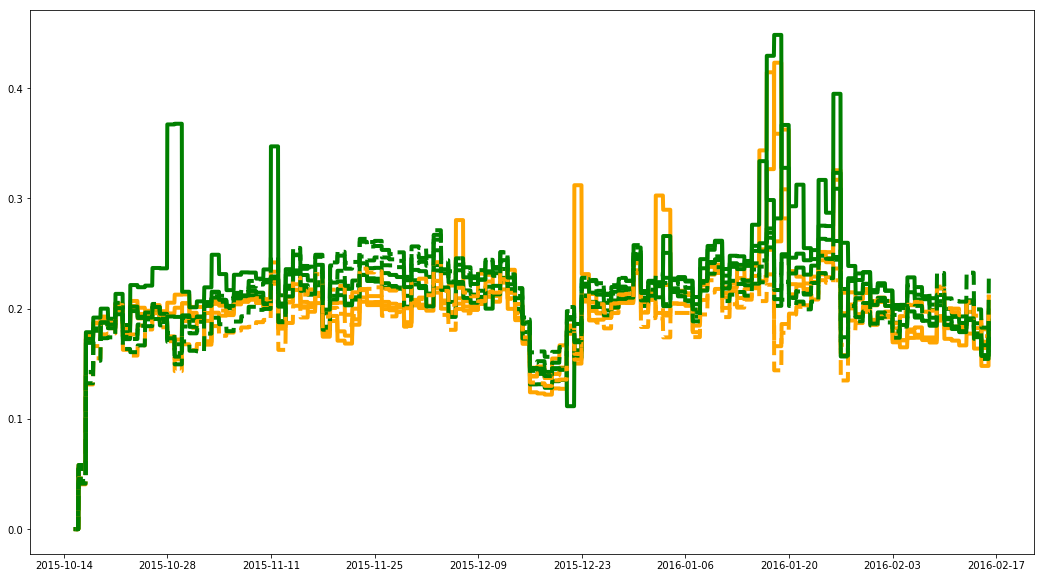

In [13]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(AlbedoHourly,ax,GPs,4)

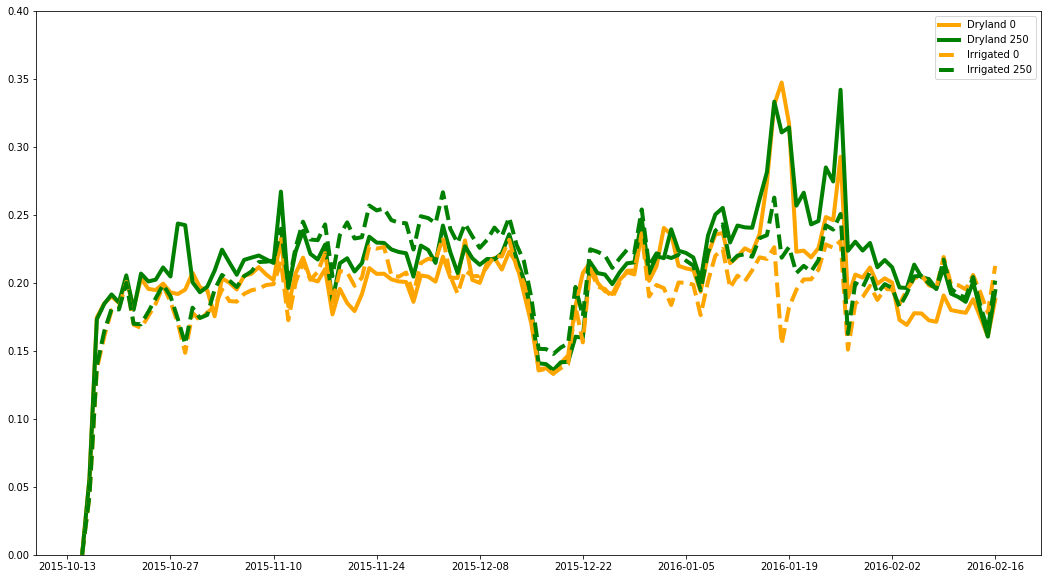

In [17]:
AlbedoDaily = AlbedoHourly.resample('D').mean().groupby(level=('Irrigation','Nitrogen'),axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(AlbedoDaily,ax,GPs,4)
plt.ylim(0,0.4)
plt.legend()

In [19]:
RnDF = pd.DataFrame(index=AlbedoHourly.index,columns=AlbedoHourly.columns)
RnDF.sort_index(axis=0, inplace=True)
RnDF.sort_index(axis=1, inplace=True)
for plot in RnDF.columns:
    RnDF.loc[:,plot] = [et.NetRadiation(TnRHourlySums.loc[x,'IncomingRadnMJ'].values[0],
                              TnRHourlyMeans.loc[x,'AirTemperature'].values[0],
                              TnRHourlyMeans.loc[x,'VP'].values[0],
                              Lattitude,
                              x.dayofyear,
                              TnRHourlyMeans.loc[x,'Duration'].values[0],
                              TnRHourlyMeans.loc[x,'Time'].values[0],
                              LongitudeTZ,
                              LongitudeML,
                              AlbedoHourly.loc[x,plot]) for x in RnDF.index]  

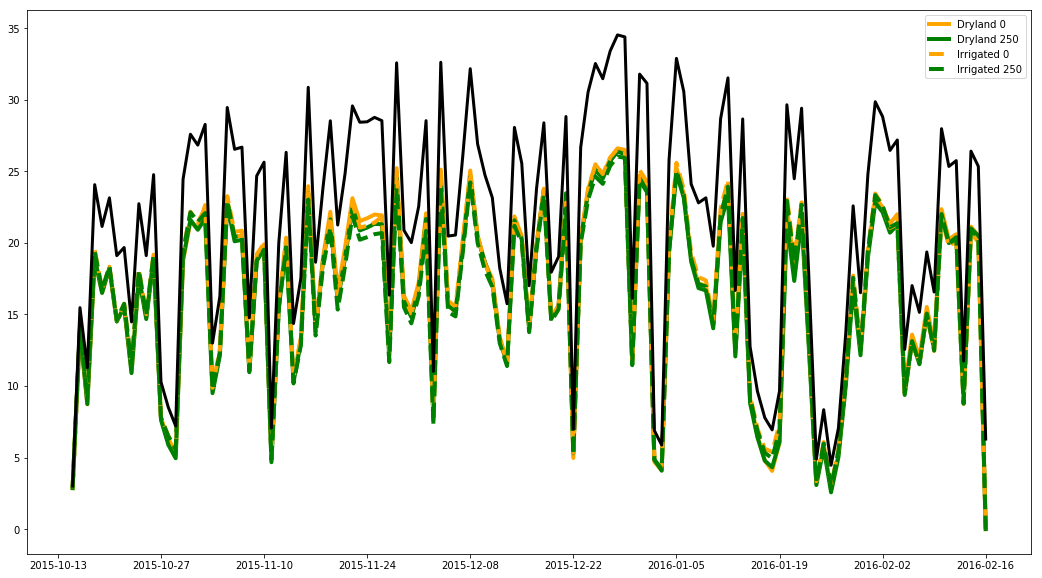

In [23]:
RnDaily = RnDF.resample('D').sum().groupby(level=('Irrigation','Nitrogen'),axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(RnDaily,ax,GPs,4)
plt.plot(TnRHourlySums.loc[:,'IncomingRadnMJ'].resample('D').sum(),color='k',linewidth=3)
plt.legend()

## Convert radiation to W/m2

In [24]:
RnDF.index.name='Date'
RnDFLong = RnDF.unstack()
RnDFLong.name='Rn'
RnDFLong.to_pickle('.\DataFrames/NetRadiationMJ.pkl')
RnDFLong = RnDFLong * 1000000 / (60 * 60)

In [26]:
RnDFLong.name = 'Rn'

In [27]:
RnDFLong.to_pickle('.\DataFrames/NetRadiation.pkl')

## Set up data frame for net Radiation estimated for all plots

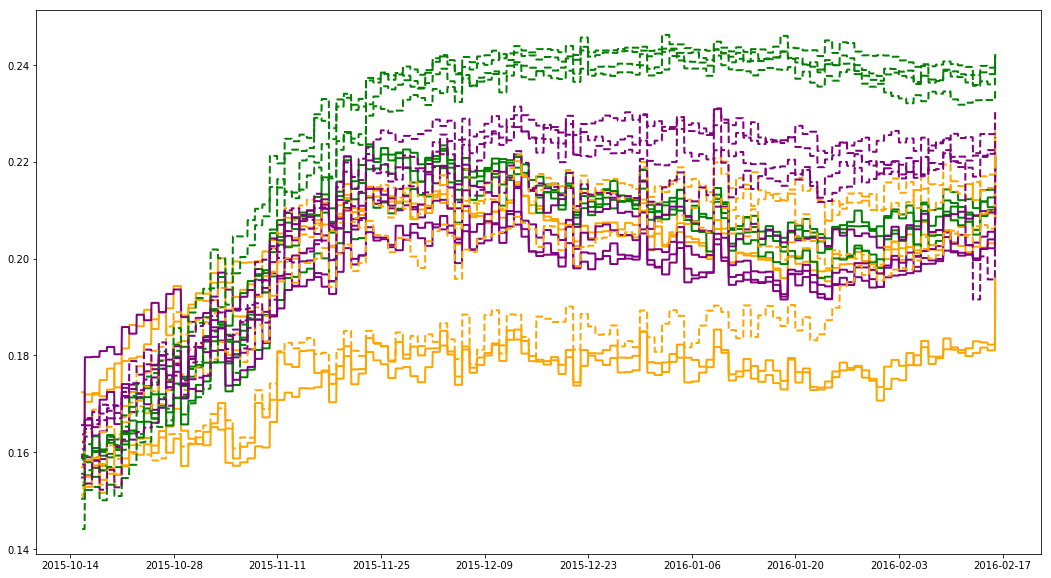

In [30]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(EstAlbedoHourly,ax,GPs,2)

In [37]:
EstRnDF = pd.DataFrame(index=TnRHourlyMeans.index,columns=TnRHourlyMeans.BelowCanopyPAR.columns)
for plot in EstRnDF.columns:
    EstRnDF.loc[:,plot] = [et.NetRadiation(TnRHourlySums.loc[x,'IncomingRadnMJ'].values[0],
                              TnRHourlyMeans.loc[x,'AirTemperature'].values[0],
                              TnRHourlyMeans.loc[x,'VP'].values[0],
                              Lattitude,
                              x.dayofyear,
                              TnRHourlyMeans.loc[x,'Duration'].values[0],
                              TnRHourlyMeans.loc[x,'Time'].values[0],
                              LongitudeTZ,
                              LongitudeML,
                              EstAlbedoHourly.loc[x,plot]) for x in RnDF.index]  

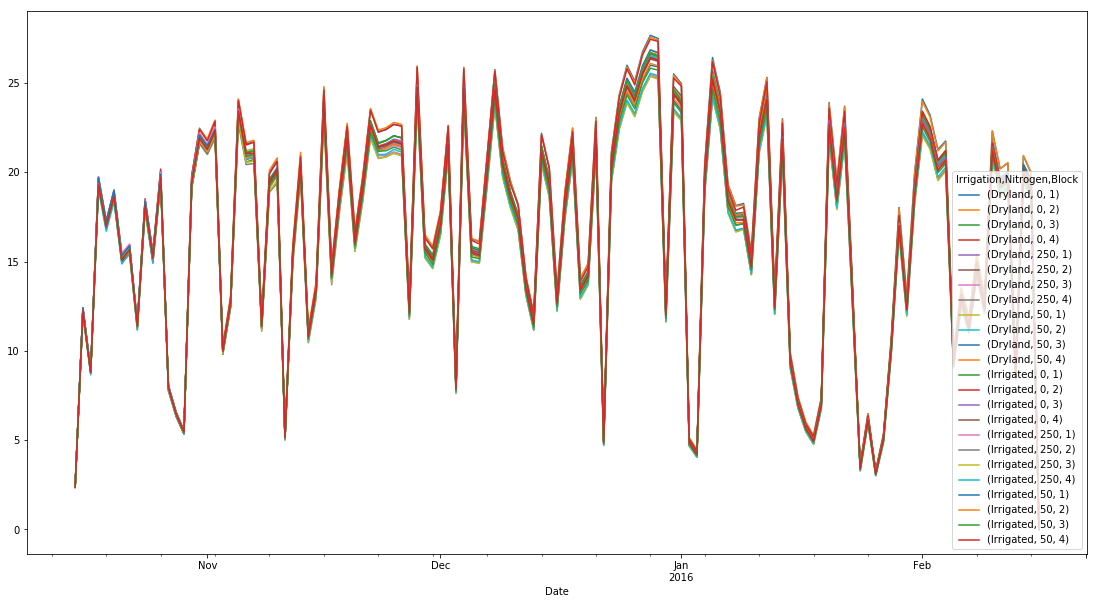

In [38]:
EstRnDF.resample('D').sum().plot(figsize=(19,10))

## Make Long

In [39]:
EstRnDF.index.name='Date'
EstRnDFDaily = EstRnDF.resample('D').sum()
EstRnDFLong = EstRnDFDaily.unstack()
EstRnDFLong = EstRnDFLong

In [42]:
EstRnDFLong.to_pickle('.\DataFrames\EstNetRadiation.pkl')

In [44]:
RnDF2 = pd.DataFrame(index=TnRHourlyMeans.index,columns=TnRHourlyMeans.BelowCanopyPAR.columns)
for plot in RnDF2.columns:
    RnDF2.loc[:,plot] = [et.NetRadiation(TnRHourlySums.loc[x,'IncomingRadnMJ'][0],
                              TnRHourlyMeans.loc[x,'IR_SurfaceTemp'].loc[plot[0:2]].iloc[int(plot[2])-1],
                              TnRHourlyMeans.loc[x,'VP'][0],
                              Lattitude,
                              x.dayofyear,
                              TnRHourlyMeans.loc[x,'Duration'][0],
                              TnRHourlyMeans.loc[x,'Time'][0],
                              LongitudeTZ,
                              LongitudeML,
                              AlbedoHourly.loc[x,plot]) for x in RnDF2.index]  

KeyError: 76

In [ ]:
Rn2Daily = RnDF2.resample('D').sum().groupby(level=('Cultivar','Irrigation'),axis=1).mean()
lines = ['--','--','-','-']
colors= ['b','r','b','r']
Graph = plt.figure(figsize=(18,10),)
pos=0
for treat in Rn2Daily:
    plt.plot(Rn2Daily.loc[:,treat].index,Rn2Daily.loc[:,treat],lines[pos],color=colors[pos],linewidth=3,label=treat)
    pos+=1
plt.plot(TnRHourlySums.loc[:,'IncomingRadnMJ'].resample('D').sum(),color='y',linewidth=3)
plt.legend()

In [ ]:
RnDF2.loc['2015-01-04':'2015-01-14',:].plot(legend=False,figsize=(19,10))

In [ ]:
plt.plot(RnDF2.loc['2015-01-04':'2015-01-14',('Dash','Low','1')],RnDF.loc['2015-01-04':'2015-01-14',('Dash','Low','1')])

In [ ]:
TnRHourlyMeans.iloc[1455:1460,:]['IR_SurfaceTemp'].plot(legend=False)

In [ ]:
RnDaily = RnDF.resample('D').sum().groupby(level=('Cultivar','Irrigation'),axis=1).mean()
lines = ['--','--','-','-']
colors= ['b','r','b','r']
Graph = plt.figure(figsize=(18,10),)
pos=0
for treat in RnDaily:
    plt.plot(RnDaily.loc[:,treat].index,RnDaily.loc[:,treat],lines[pos],color=colors[pos],linewidth=3,label=treat)
    pos+=1
plt.plot(TnRHourlySums.loc[:,'IncomingRadnMJ'].resample('D').sum(),color='y',linewidth=3)
plt.legend()